# Chapter 07 
 Machine Learning for Business Analytics<br>
Concepts, Techniques, and Applications in Python<br>
by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

Publisher: Wiley; 2nd edition (2024) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2024 Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors.
"Warnings" are for information only and can usually be ignored.
"Errors" will stop execution and need to be fixed in order to get results.

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/sdsa-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Report the problem using the issue tracker at https://github.com/gedeck/sdsa-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [2]:
import matplotlib.pyplot as plt
import mlba
import pandas as pd
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
%matplotlib inline

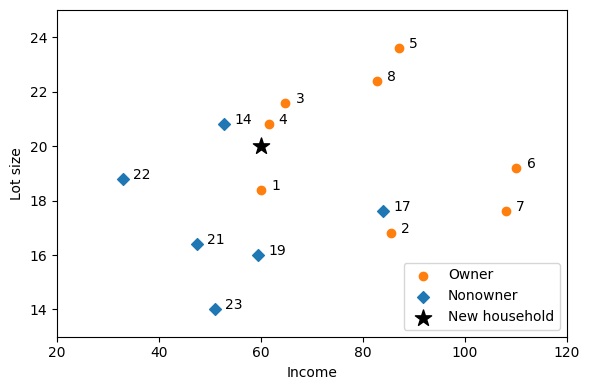

In [3]:
mower_df = mlba.load_data('RidingMowers.csv')
mower_df['Number'] = mower_df.index + 1

trainData, holdoutData = train_test_split(mower_df, test_size=0.4, random_state=26)

## new household
newHousehold = pd.DataFrame([{'Income': 60, 'Lot_Size': 20}])

## scatter plot
def plotDataset(ax, data):
    subset = data.loc[data['Ownership']=='Owner']
    ax.scatter(subset.Income, subset.Lot_Size, marker='o',
        label='Owner', color='C1')
    subset = data.loc[data['Ownership']=='Nonowner']
    ax.scatter(subset.Income, subset.Lot_Size, marker='D',
        label='Nonowner', color='C0')
    for _, row in data.iterrows():
        ax.annotate(row.Number, (row.Income + 2, row.Lot_Size))

fig, ax = plt.subplots(figsize=(6, 4))
plotDataset(ax, trainData)
ax.scatter(newHousehold.Income, newHousehold.Lot_Size, marker='*',
    label='New household', color='black', s=150)

ax.set_xlabel('Income'); ax.set_ylabel('Lot size')
ax.set_xlim(20, 120)
ax.set_ylim(13, 25)
ax.legend(loc=4)
plt.tight_layout()
plt.show()

In [4]:
predictors = ['Income', 'Lot_Size']
outcome = 'Ownership'

# combine scaling and k-NN classifier into model using a pipeline
model = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=3)),
])

model.fit(trainData[predictors], trainData[outcome])
model.predict(newHousehold)

array(['Owner'], dtype=object)

 Determine the nearest neighbors of the new household

In [5]:
zNewHousehold = model['scaler'].transform(newHousehold)
distances, indices = model['knn'].kneighbors(zNewHousehold)
trainData.iloc[indices[0], :]

,Income,Lot_Size,Ownership,Number
3,61.5,20.8,Owner,4
13,52.8,20.8,Nonowner,14
0,60.0,18.4,Owner,1


In [6]:
X = trainData[predictors]
y = trainData[outcome]
results = []
for k in range(1, 14):
    # set the number of neighbors in the knn model
    model.set_params(knn__n_neighbors=k)
    accuracy = cross_val_score(model, X, y, cv=LeaveOneOut(), scoring='accuracy').mean()
    results.append({'k': k, 'accuracy': accuracy})
pd.DataFrame(results).round(2)

,k,accuracy
0,1,0.71
1,2,0.50
2,3,0.71
3,4,0.71
4,5,0.79
5,6,0.71
6,7,0.79
7,8,0.71
8,9,0.71
9,10,0.57


In [7]:
# Retrain with full dataset
knn = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
])
knn.fit(mower_df[predictors], mower_df[outcome])

zNewHousehold = knn['scaler'].transform(newHousehold)
distances, indices = knn['knn'].kneighbors(zNewHousehold)

print('Predicted class', knn.predict(newHousehold))
print('Probability', knn.predict_proba(newHousehold))
print('Distances',distances)
print('Indices', indices)
print(mower_df.iloc[indices[0], :])

Predicted class ['Owner']
Probability [[0.2 0.8]]
Distances [[0.34532669 0.46448259 0.50133206 0.67307542 0.71721526]]
Indices [[ 3  8 13  0  2]]
    Income  Lot_Size Ownership  Number
3     61.5      20.8     Owner       4
8     69.0      20.0     Owner       9
13    52.8      20.8  Nonowner      14
0     60.0      18.4     Owner       1
2     64.8      21.6     Owner       3


In [8]:
# Train weighted k-nearest neighbor model with full dataset
knn = Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance')),
])
knn.fit(mower_df[predictors], mower_df[outcome])

zNewHousehold = knn['scaler'].transform(newHousehold)
distances, indices = knn['knn'].kneighbors(zNewHousehold)

print('Predicted class', knn.predict(newHousehold))
print('Probability', knn.predict_proba(newHousehold))

Predicted class ['Owner']
Probability [[0.20100777 0.79899223]]


In [9]:
df = pd.DataFrame({
    'Family': ['Single', 'Married', 'Married', 'Single', 'Married', 'Married'],
    'Car': ['SUV', 'SUV', 'Sports', 'Truck', 'Sports', 'Sports'],
    'Income': [49, 34, 11, 100, 45, 29],
    'CreditCard': [1, 1, 3, 1, 2, 2],
})
preprocess = ColumnTransformer([
    ('encoder', preprocessing.OneHotEncoder(drop='if_binary'), ['Family', 'Car']),
    ('standardize', preprocessing.StandardScaler(), ['Income']),
    ('unchanged', 'passthrough', ['CreditCard']),
])
preprocess.fit_transform(df).round(4)

array([[ 1.    ,  1.    ,  0.    ,  0.    ,  0.157 ,  1.    ],
       [ 0.    ,  1.    ,  0.    ,  0.    , -0.3864,  1.    ],
       [ 0.    ,  0.    ,  1.    ,  0.    , -1.2194,  3.    ],
       [ 1.    ,  0.    ,  0.    ,  1.    ,  2.0042,  1.    ],
       [ 0.    ,  0.    ,  1.    ,  0.    ,  0.0121,  2.    ],
       [ 0.    ,  0.    ,  1.    ,  0.    , -0.5675,  2.    ]])